This code is copied from https://sjster.github.io/introduction_to_computational_statistics/docs/Production/PyMC3.html#an-example-with-linear-regression

The original code was written to use PyMC3. It has been modofied to work with the latest PyMC package which has some API differences:

1. import pymc instead of pymc3
2. Normal distribution parameter for standard deviation has been renamed from sd to sigma
3. 

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import arviz as az
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import graphviz
import os

os.environ['OMP_NUM_THREADS'] = '4'

# Initialize random number generator
np.random.seed(123)

# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.linspace(0, 1, size)
X2 = np.linspace(0,.2, size)

# Simulate outcome variable
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma

In [2]:
import pymc as pm
from pymc import Model, Normal, HalfNormal
from pymc import find_MAP

# Model Setup in PyMC

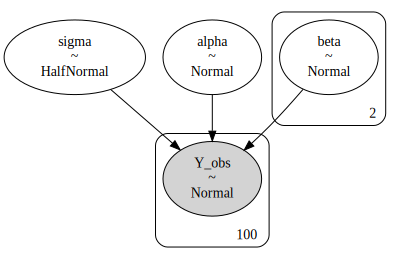

In [3]:
basic_model = Model()

with basic_model:

    # Priors for unknown model parameters
    alpha = Normal('alpha', mu=0, sigma=5)
    beta = Normal('beta', mu=0, sigma=5, shape=2)
    sigma = HalfNormal('sigma', sigma=4)

    # Expected value of outcome
    mu = alpha + beta[0]*X1 + beta[1]*X2 
    
    # Deterministic variable, to have PyMC3 store mu as a value in the trace use
    # mu = pm.Deterministic('mu', alpha + beta[0]*X1 + beta[1]*X2)
    
    # Likelihood (sampling distribution) of observations
    Y_obs = Normal('Y_obs', mu=mu, sigma=sigma, observed=Y)

pm.model_to_graphviz(basic_model)

# MAP Estimate

PyMC3 computes the MAP estimate using numerical optimization, by default using the BFGS algorithm. These provide a point estimate which may not be accurate if the mode does not appropriately represent the distribution.

In [4]:
map_estimate = find_MAP(model=basic_model, maxeval=10000)
map_estimate

Output()

{'alpha': array(1.01541828),
 'beta': array([1.46379682, 0.29275936]),
 'sigma_log__': array(0.12023665),
 'sigma': array(1.12776371)}

# Inference in PyMC

In [5]:
from pymc import NUTS, sample
from scipy import optimize

In [6]:
with basic_model:
    
    # obtain starting values via MAP
    #start = find_MAP(fmin=optimize.fmin_powell)
    # start = find_MAP(method='Powell')

    # instantiate sampler - not really a good practice
    # step = NUTS(scaling=start)

    # draw 2000 posterior samples
    # trace = sample(2000, step, start=start)
    trace = sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 8 seconds.


# Distribution Information through Traceplots

In [7]:
# trace['alpha']
trace.posterior['alpha'].to_numpy()

array([[1.20636818, 0.93929005, 0.93884448, ..., 1.16042891, 1.15884062,
        0.87876883],
       [0.8458424 , 0.86836009, 1.11084402, ..., 1.17518929, 1.6625481 ,
        0.58067987],
       [1.11520903, 1.27043687, 1.32148498, ..., 0.76999081, 0.99753871,
        0.87242316],
       [1.04208029, 0.80771359, 1.1624758 , ..., 0.98061141, 0.92303654,
        0.63641868]])

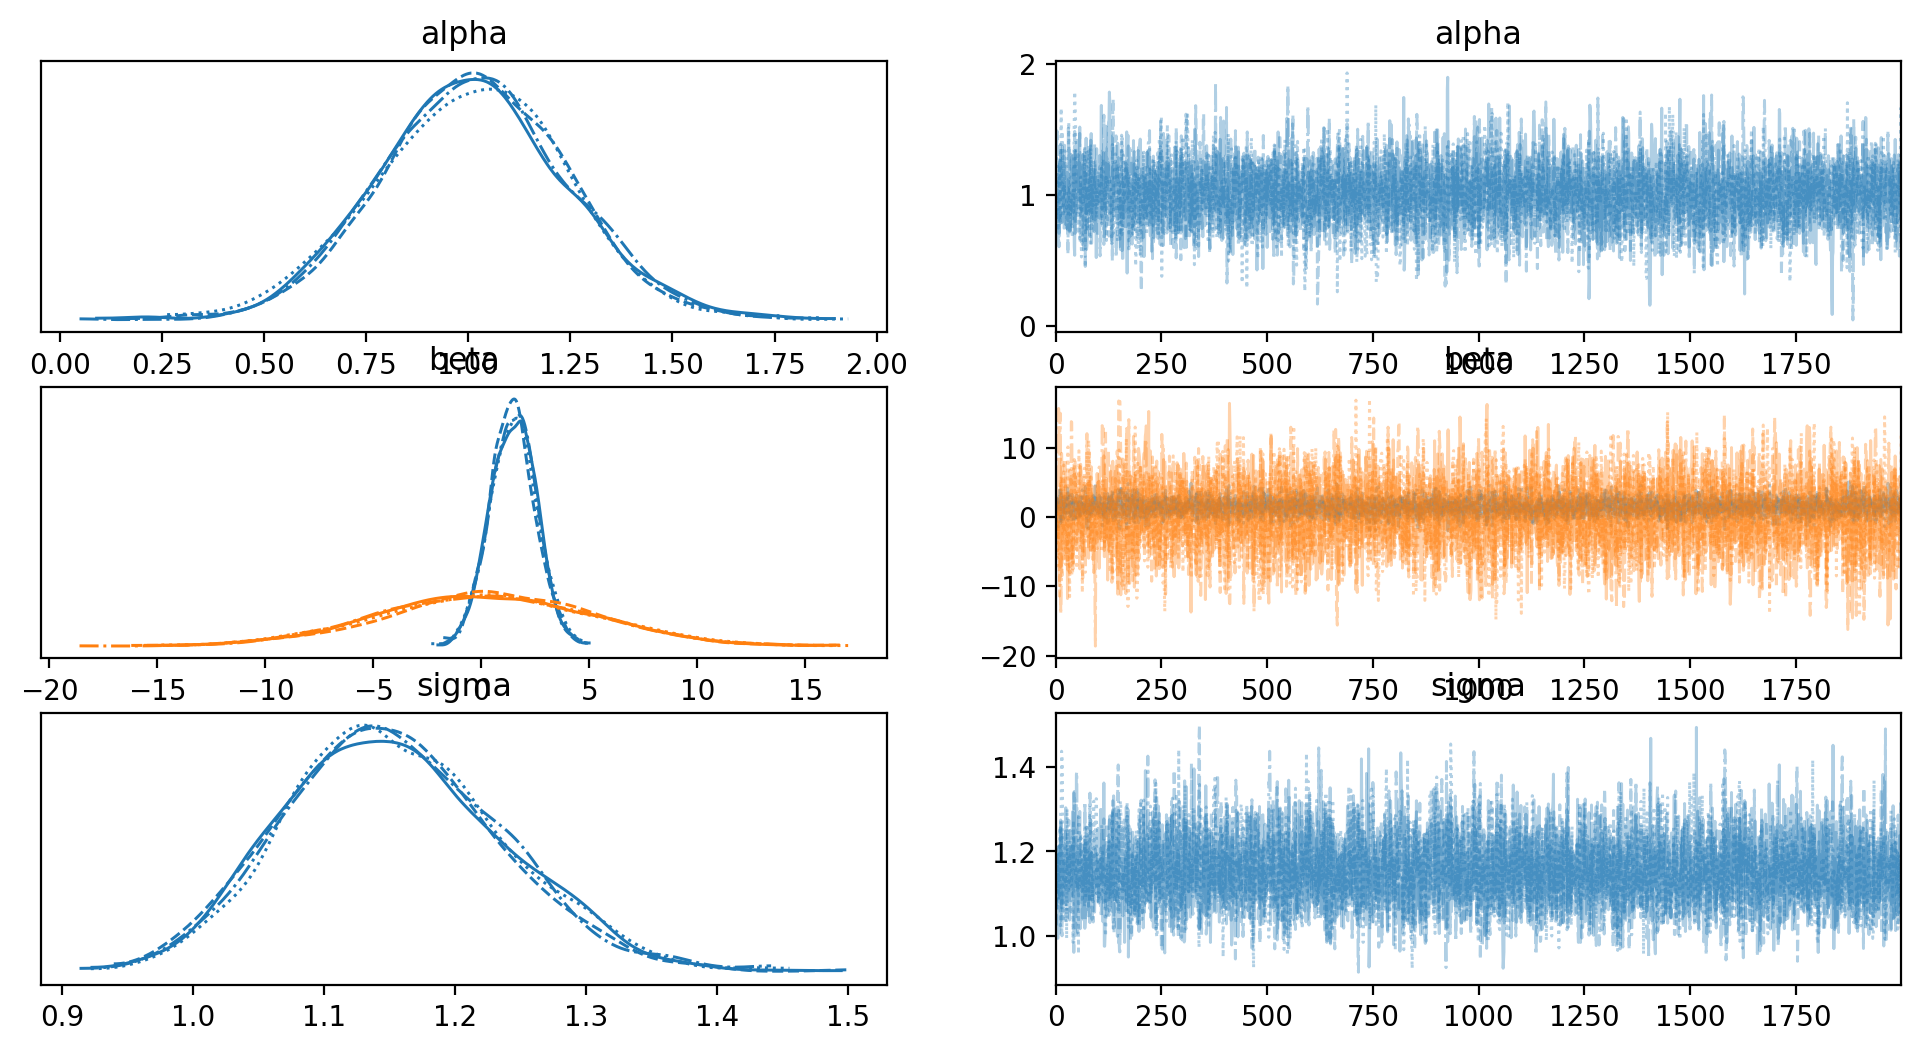

In [8]:
#from pymc import traceplot
#traceplot(trace)
pm.plot_trace(trace)
plt.show();

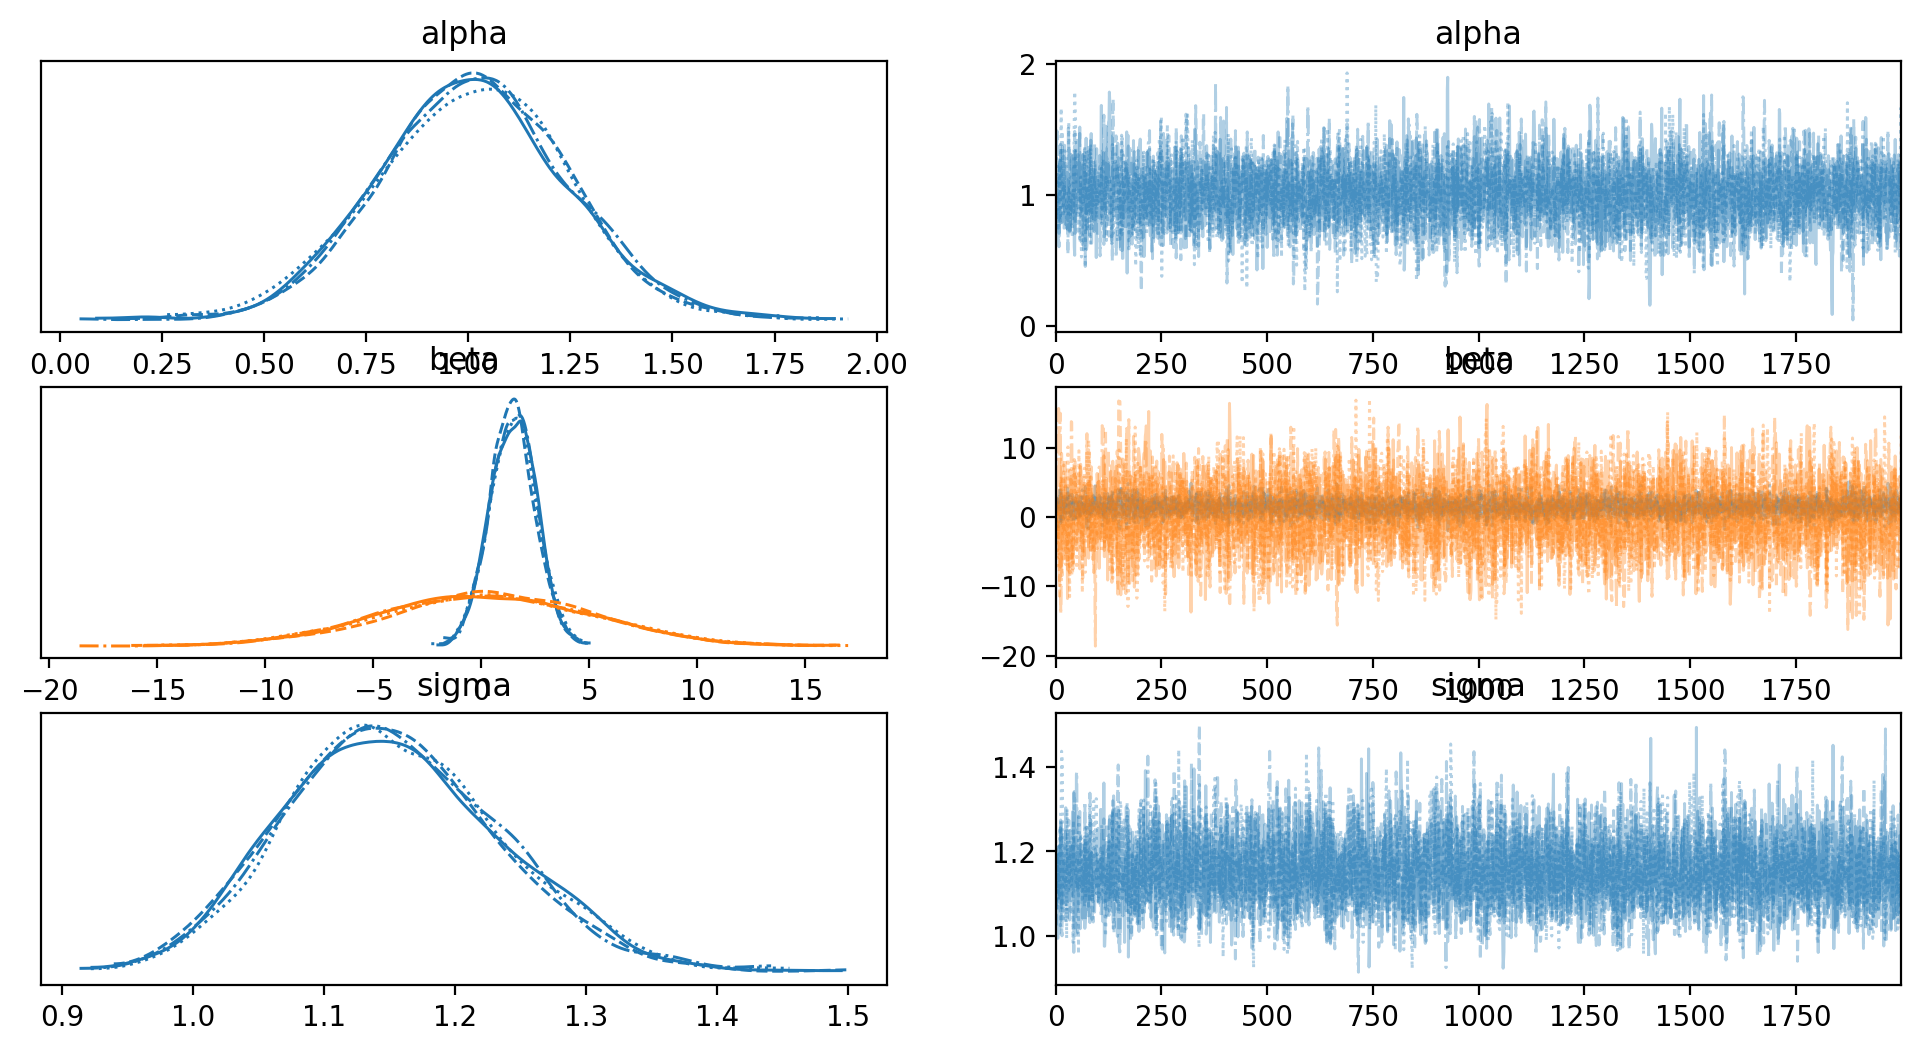

In [9]:
az.plot_trace(trace)
plt.show()

We will look at the summary of the sampling process. The columns will be explained as we progress through this course.

In [10]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.011,0.231,0.573,1.431,0.003,0.002,4692.0,4366.0,1.0
beta[0],1.476,1.062,-0.551,3.446,0.020,0.014,2953.0,3456.0,1.0
beta[1],0.263,4.929,-8.855,9.635,0.088,0.062,3173.0,3737.0,1.0
sigma,1.153,0.083,1.002,1.308,0.001,0.001,5617.0,4701.0,1.0


In [11]:
from pymc import summary
summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.011,0.231,0.573,1.431,0.003,0.002,4692.0,4366.0,1.0
beta[0],1.476,1.062,-0.551,3.446,0.020,0.014,2953.0,3456.0,1.0
beta[1],0.263,4.929,-8.855,9.635,0.088,0.062,3173.0,3737.0,1.0
sigma,1.153,0.083,1.002,1.308,0.001,0.001,5617.0,4701.0,1.0


### Composition of Distributions for Uncertainty

You can do the same without observations, to perform computations and get uncertainty quantification. In this example add two normally distributed variables to get another normally distributed variable. By definition

$$\mu_c = \mu_a + \mu_b $$

$$\sigma_c^2 = \sigma_a^2 + \sigma_b^2$$

In [12]:
basic_model2 = Model()

with basic_model2:

    # Priors for unknown model parameters
    alpha = Normal('alpha', mu=20, sigma=5)
    beta = Normal('beta', mu=10, sigma=5, shape=1)
    # These aren't used in the calculation, but please experiment by composing various combinations
    # of these function for calculating mu
    sigma = HalfNormal('sigma', sigma=1)
    σ_obs = pm.HalfCauchy("σ_obs", beta=1, testval=0.1)

    # Expected value of outcome
    mu = pm.Deterministic('mu', alpha + beta) 
    
    trace = sample(15000)
    
# print(trace['mu'])
# traceplot(trace)   

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma, σ_obs]


Output()

Sampling 4 chains for 1_000 tune and 15_000 draw iterations (4_000 + 60_000 draws total) took 16 seconds.
There were 66 divergences after tuning. Increase `target_accept` or reparameterize.


In [13]:
trace.posterior['mu'].to_numpy()

array([[[30.61308049],
        [27.56676126],
        [34.82673379],
        ...,
        [26.38499967],
        [23.04904282],
        [31.6444332 ]],

       [[29.73988068],
        [28.88433813],
        [21.17194227],
        ...,
        [22.82470202],
        [27.68986052],
        [38.37187721]],

       [[21.03628312],
        [20.55979484],
        [39.85998353],
        ...,
        [22.76979315],
        [25.65514704],
        [27.89364731]],

       [[21.41801049],
        [41.14175454],
        [31.16166274],
        ...,
        [35.15753325],
        [47.26521635],
        [ 5.7013251 ]]])

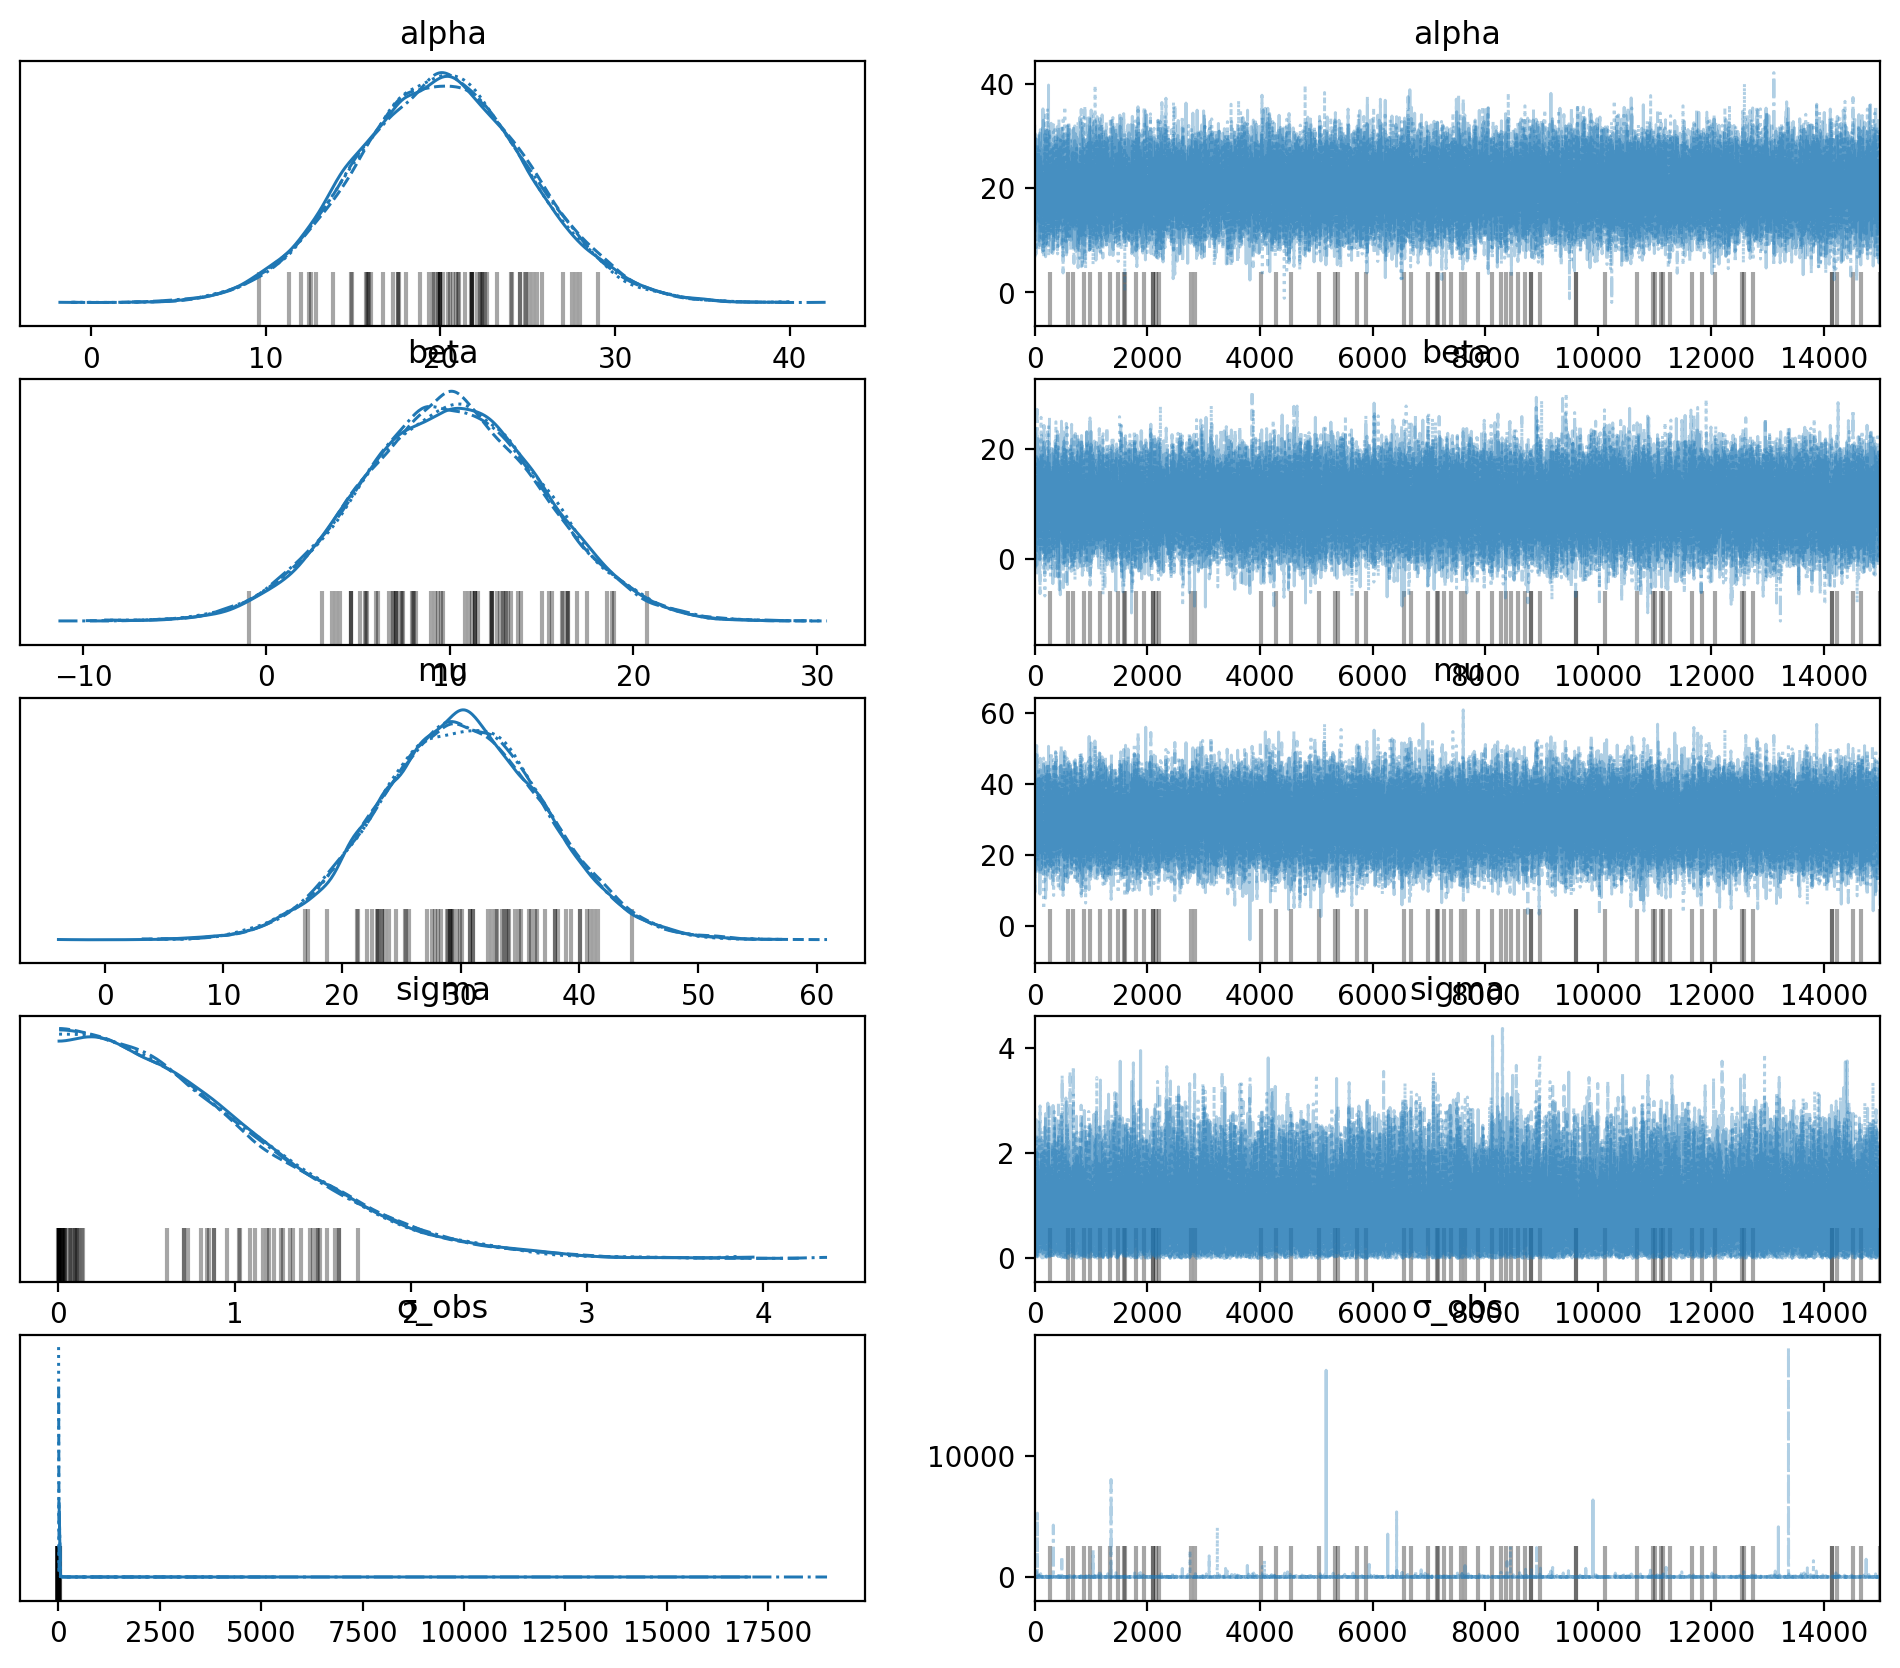

In [14]:
az.plot_trace(trace)
plt.show()

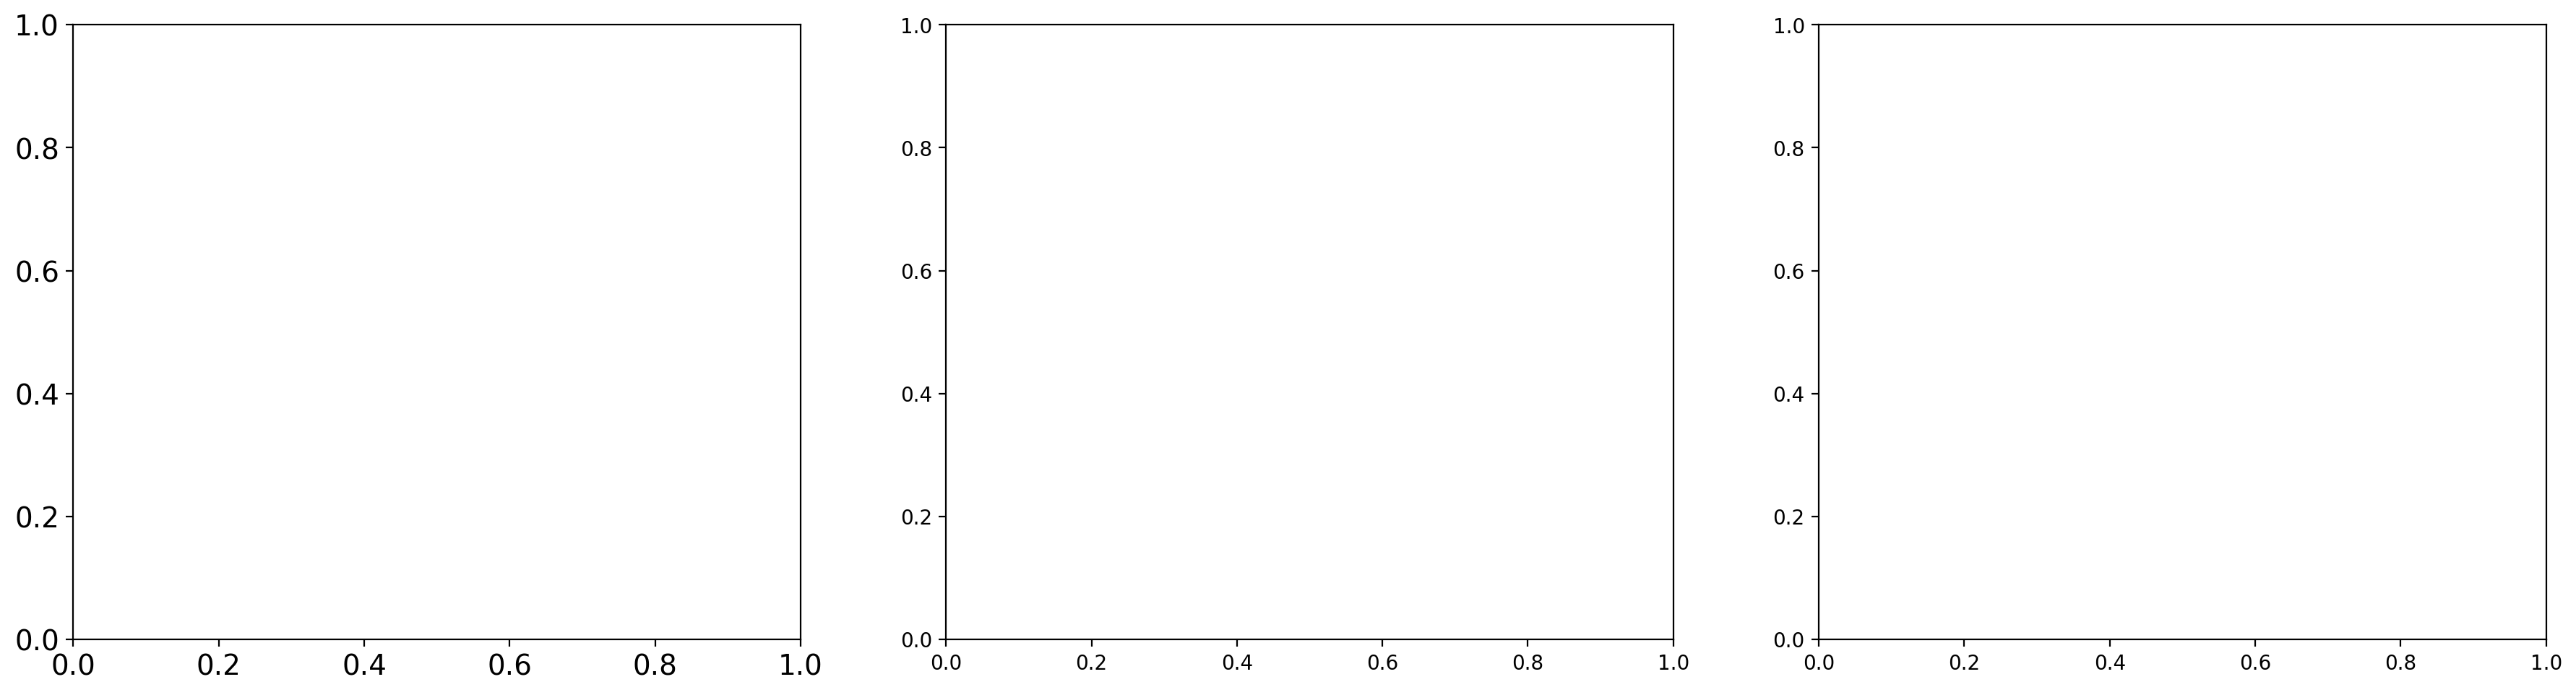

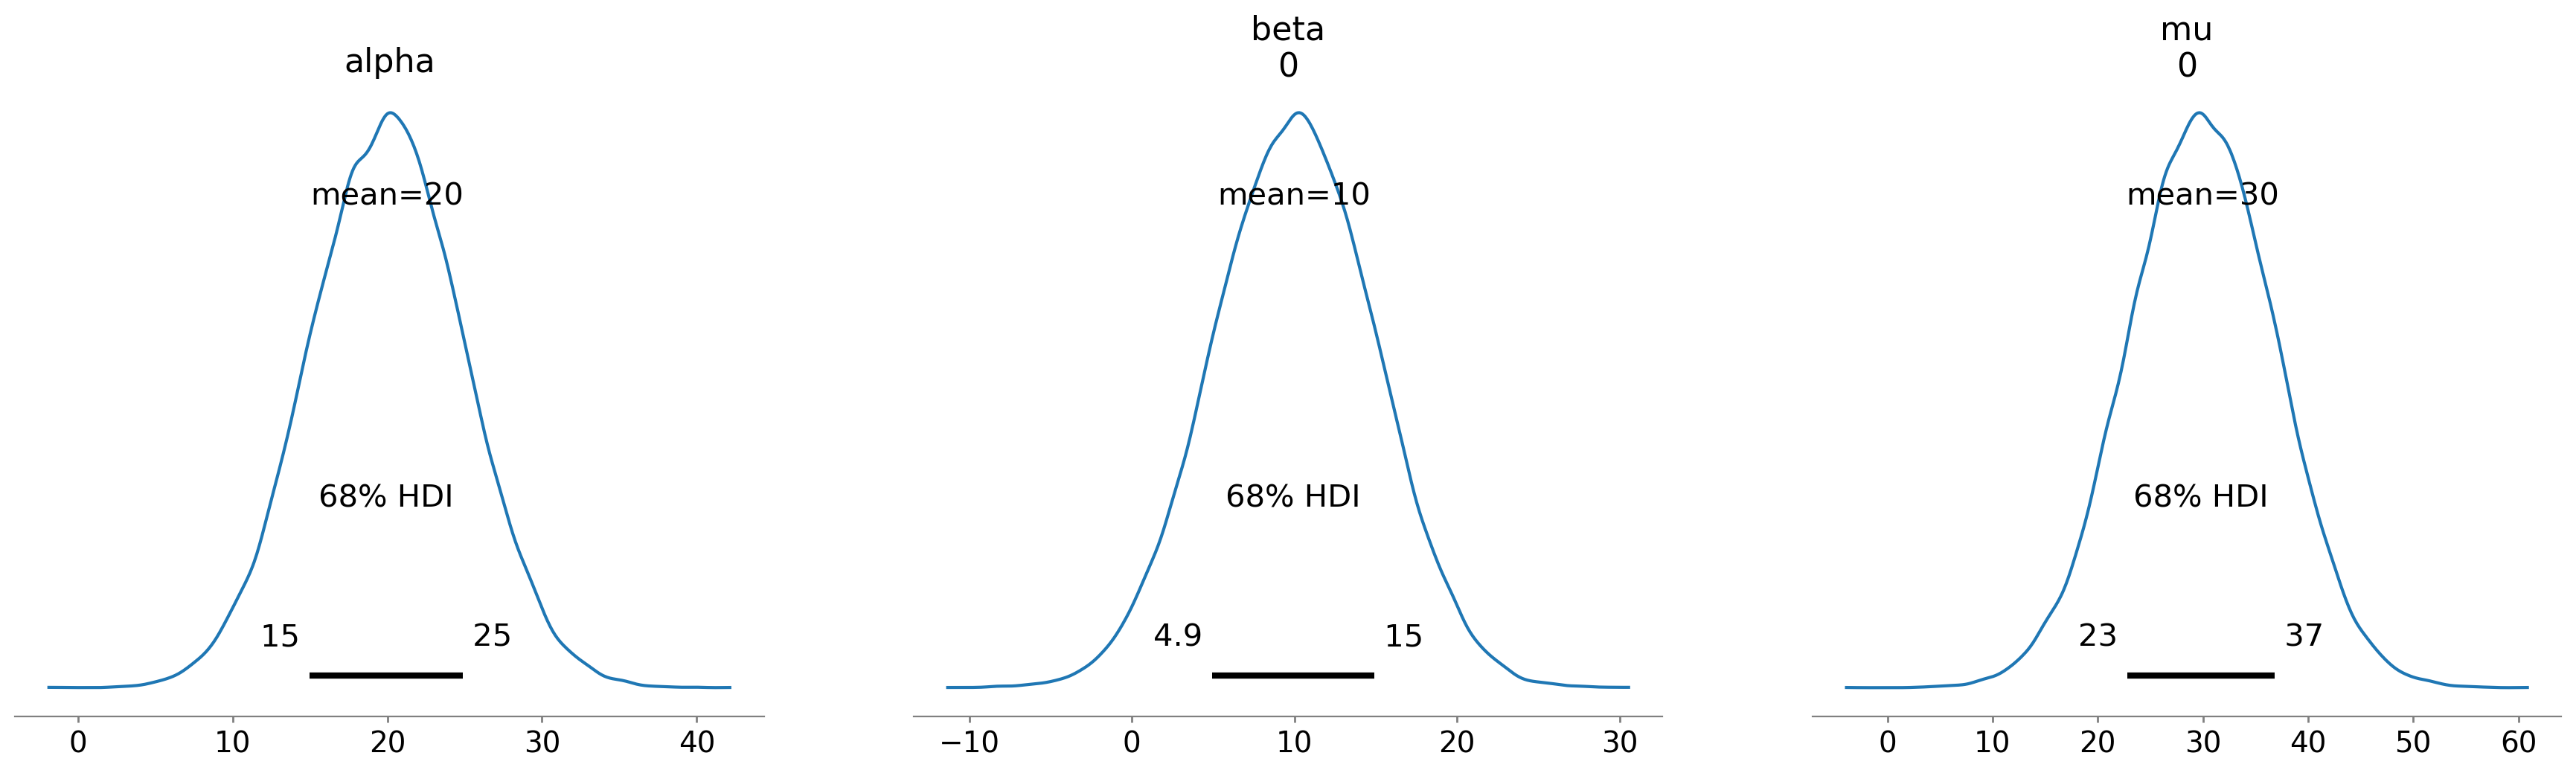

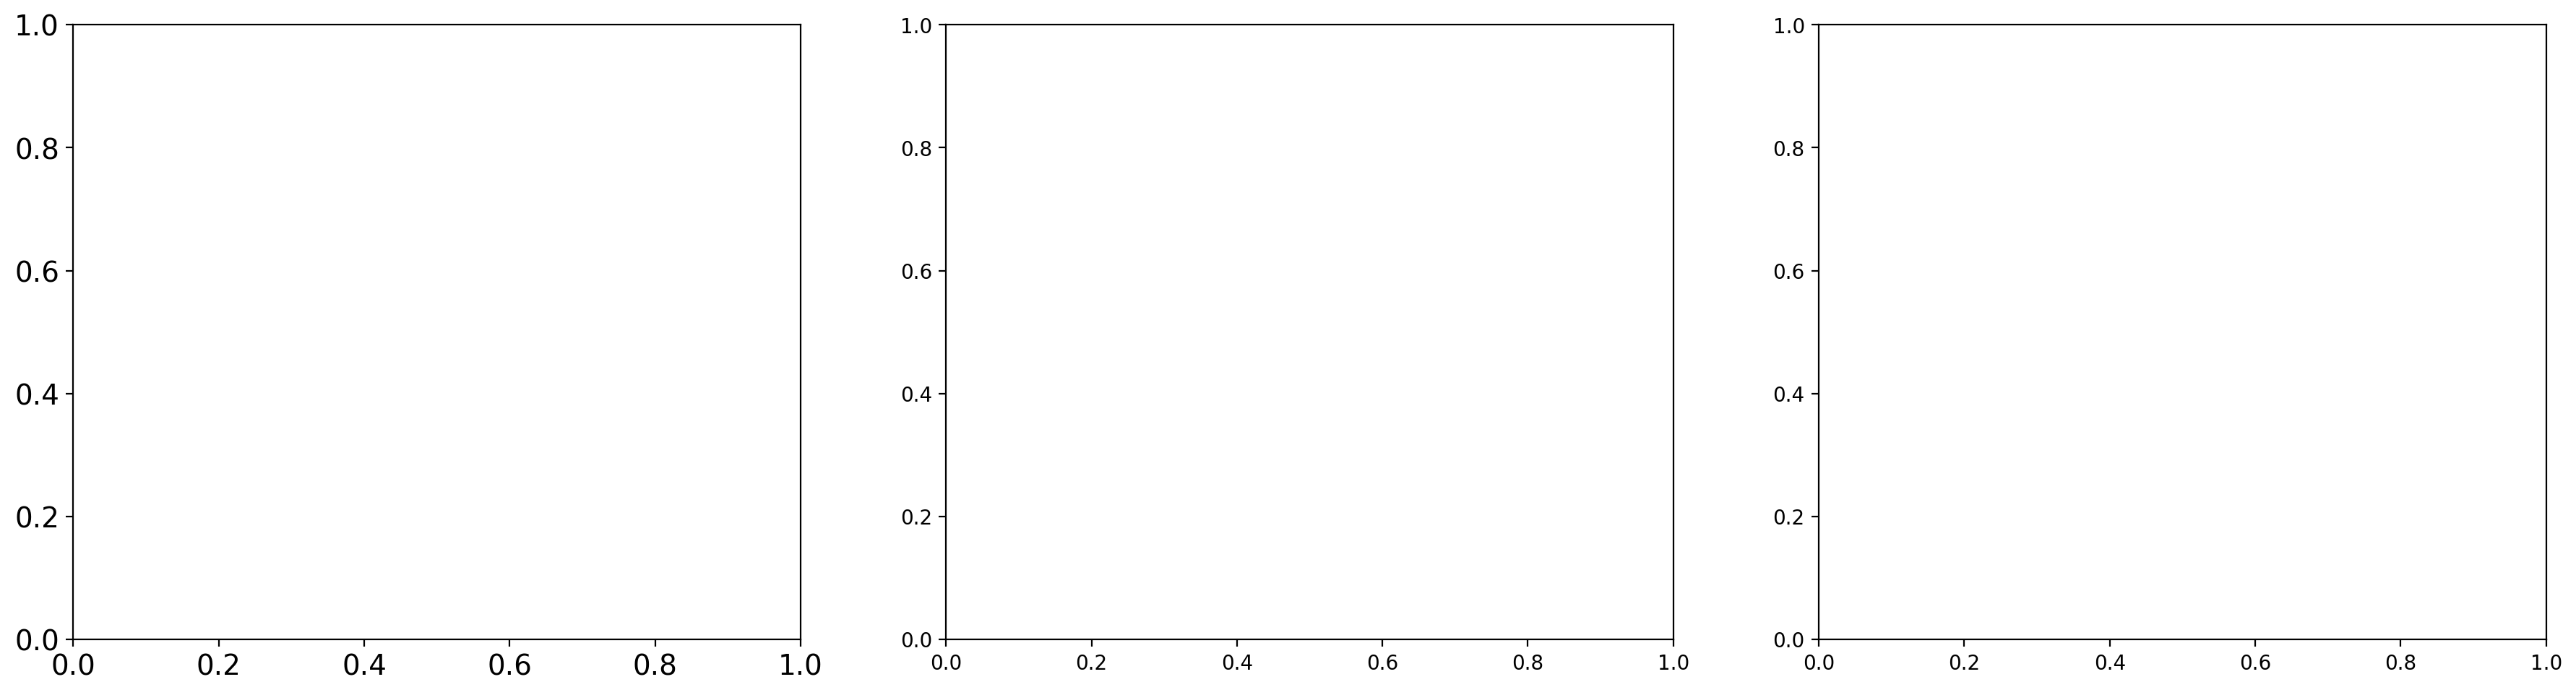

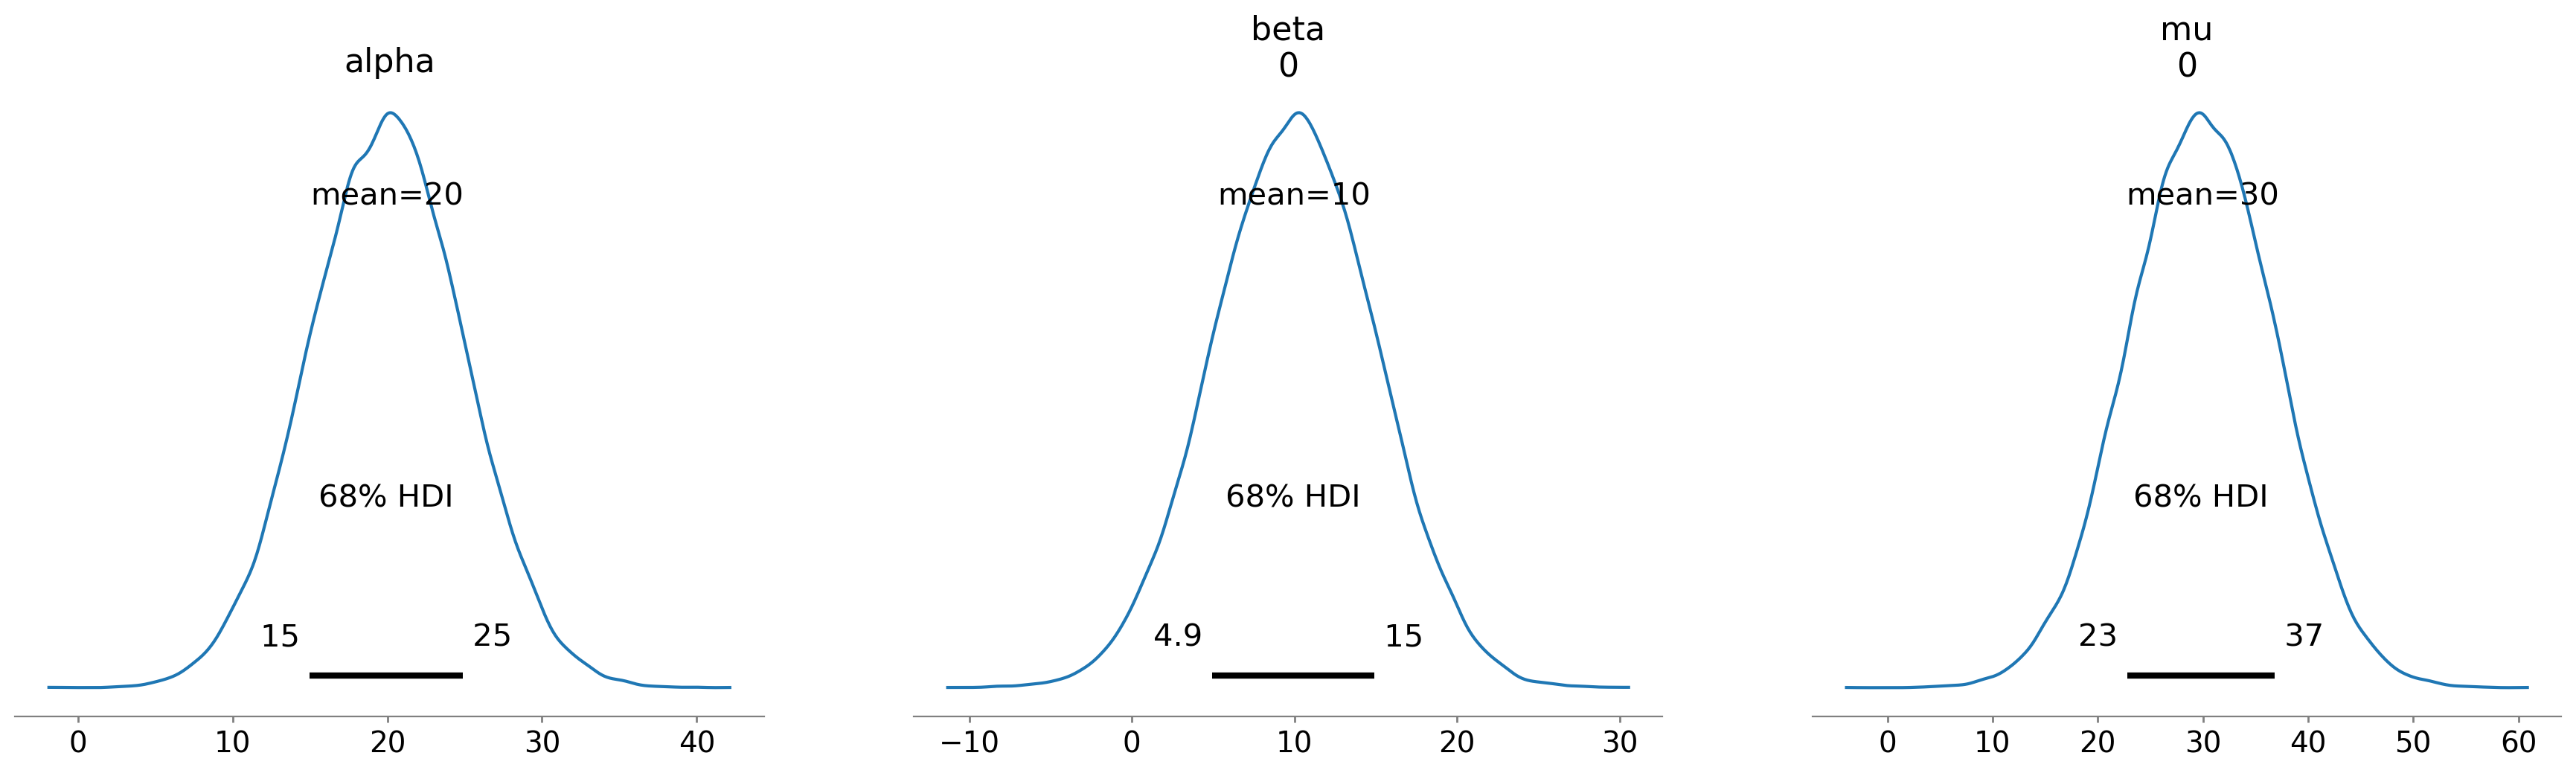

In [18]:
# Note the mean and standard deviation of the variable mu. We didn't need observations to compute this uncertainty.
try:
    # older syntax
    pm.plot_posterior(trace, var_names=['alpha', 'beta', 'mu'], credible_interval=0.68)
except:
    pm.plot_posterior(trace, var_names=['alpha', 'beta', 'mu'], hdi_prob=0.68)
    plt.show()

### GRADED EVALUATION (5 mins)

1. What type of algorithms does PyMC3 support?

   a. MCMC
   
   b. Variational Inference
   
   c. Both
   
   
2. We can mix Deterministic and Probabilistic variables in PyMC3

   a. True
   
   b. False